This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Multi File OdimH5 reader

This implementation is based on several classes which are described below.

## Class Overview

### XRadBase

Implements `collections.abc.MutableSequence` for holding sequential data in the derived classes (eg. sweeps, timeseries, moments).

### OdimH5GroupAttributeMixin

Implements properties for `XRadMoment`, `XRadSweep`, `XRadTimeSeries` and `XRadVolume` to nicely acquire ODIM group metadata, eg. `how`, `what` and `where` groups. Other wanted attributes can be acquired via `attrs`-property and other (sub-) groups be inspected via `groups`-property.

### OdimH5SweepMetaDataMixin

Implements properties for `XRadSweep` to nicely acquire ODIM sweep metadata, eg. `a1gate`, `azimuth`, `nrays`, `nbins` etc.

### XRadMoment

Uses `OdimH5GroupAttributeMixin` to access ODIM metadata. Does not hold any data. Property `data` fetches the moment as xarray DataArray from the parent `XRadSweep`. 

### XRadSweep

Inherits from `XRadBase`, uses `OdimH5GroupAttributeMixin` and `OdimH5SweepMetaDataMixin`. Worker class, where everything happens. Implements methods and properties to retrieve sweep metadata and data. Holds `XRadMoments` in it's `MutableSequence`. Property `data` is used to load and cache the `XRadMoments` as combined xarray Dataset. Implements a whole arsenal of other properties to inspect metadata.

#### XRadSweepOdim:

Inherits from `XRadSweep`. Accounts for ODIM data layout.

#### XRadSweepGamic:

Inherits from `XRadSweep`. Accounts for GAMIC data layout.

### XRadTimeSeries

Inherits from `XRadBase`, holds several `XRadSweep` objects in it's `MutableSequence`. Property `data` is used to concat and cache the `XRadSweeps` as xarray Dataset along time dimension. Implements check methods to quickly get information about layout of timeseries data. 

### XRadVolume

Inherits from `XRadBase`, holds several `XRadTimeSeries` objects in it's `MutableSequence`. Implements CfRadial2 like `root` property.

## Loading Function

For opening ODIMH5 datafiles `wrl.io.open_odim(filename, loader='h5py', **kwargs)` can be used.

The user can decide which loader to use (`h5py`, `h5netcdf` or `netcdf4`) to open the files for reading. The output should be the same in any case, although the memory footprint can differ quite substantially. The default loader is `netcdf4` if loader isn't specified.

The datasets are retrieved in further succession via `xarray.open_dataset()` in combination with either `xarray.backends.H5NetCDFStore` (for loader `h5py` and `h5netcdf`) or `xarray.backends.NetCDF4DataStore` (for loader `netcdf4`.

Possible keyword arguments are:

- `mask_and_scale` *bool* - If True, apply mask and scale to moment data arrays
- `decode_coords` *bool* - If True, decode ODIMH5 coordinates
- `decode_times` *bool* - If True, decode times into datetime objects
- `chunks` *int or dict* - Data loaded as dask array
- `parallel` *bool* - if True, use `dask.delayed` to load moments in parallel

The user is encouraged to play with the keyword arguments for best alignment with the needs in terms of speed and performance.

In [1]:
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as pl
import numpy as np
import xarray as xr
import os
import glob
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

In [2]:
import os
import psutil
import gc
process = psutil.Process(os.getpid())

In [3]:
def memory_usage_psutil():
    # return the memory usage in MB
    rocess = psutil.Process(os.getpid())
    mem = process.memory_full_info().uss / float(1 << 20)
    return mem

In [4]:
def free_memory():
    mem0 = memory_usage_psutil()
    print(gc.collect())
    proc = psutil.Process()
    mem1 = memory_usage_psutil()
    print("Memory freed: {0:.5f} MB".format((mem0-mem1)))

In [5]:
def check_open_files(full=False):
    proc = psutil.Process()
    print(len(proc.open_files()))
    if full:
        print(proc.open_files())

In [6]:
fpath = wrl.util.get_wradlib_data_path()
f = os.path.join(fpath, 'hdf5/behel/20*.hdf')

In [7]:
mem_start = memory_usage_psutil()
print("Current Memory:", mem_start)

Current Memory: 124.3359375


## Check open files

In [8]:
check_open_files()

0


## Claim Files into class structure

The different files will be opened with `h5netcdf`, `h5py` or `netcdf4` depending on `loader` keyword. Only absolutely neccessary metadata (time, elevation) is read from the files to be used for aligning into the structure.

Normally `h5py` is the most performant loader for `ODIM` data. But your mileage may vary.

This means that every file is opened once and the filehandle is distributed to `XRadSweep`. If `XRadSweep` will be destroyed, the memory will be ready for garbage collection.

Under the hood `netcdf4` or `h5netcdf` will be used to open data as `xarray.Dataset` depending on the loader-type. All filehandling issues are moved to xarray. No memory holes, no need to track filehandles.

In [9]:
%%time
vol = wrl.io.xarray.open_odim(f, loader='h5py', chunks={})

Open:   0%|          | 0/32 [00:00<?, ? Files/s]

Open:  25%|██▌       | 8/32 [00:00<00:00, 74.91 Files/s]

Open:  50%|█████     | 16/32 [00:00<00:00, 74.86 Files/s]

Open:  72%|███████▏  | 23/32 [00:00<00:00, 71.24 Files/s]

Open: 100%|██████████| 32/32 [00:00<00:00, 74.53 Files/s]

Open: 100%|██████████| 32/32 [00:00<00:00, 73.72 Files/s]


Collecting:   0%|          | 0/12 [00:00<?, ? Angles/s]

Collecting:  58%|█████▊    | 7/12 [00:00<00:00, 65.99 Angles/s]

Collecting: 100%|██████████| 12/12 [00:00<00:00, 64.98 Angles/s]

CPU times: user 748 ms, sys: 24.2 ms, total: 772 ms
Wall time: 807 ms


## Check open files

In [10]:
check_open_files()

32


## Overview type and lenght

In [11]:
print("Volume:", type(vol), len(vol))
print("TimeSeries:", type(vol[0]), len(vol[0]))
print("Sweep:", type(vol[0][0]), len(vol[0][0]))
print("Moment:", type(vol[0][0][0]), vol[0][0][0].quantity)

Volume: <class 'wradlib.io.xarray.XRadVolume'> 12
TimeSeries: <class 'wradlib.io.xarray.XRadTimeSeries'> 8
Sweep: <class 'wradlib.io.xarray.XRadSweepOdim'> 4
Moment: <class 'wradlib.io.xarray.XRadMoment'> WRAD


## Overview Contents (__repr__())

When printing the objects, they tell us a little about themselves and the data they can get access to. 

### Volume

Here we see, that it is of type `wradlib.XRadVolume`. It holds 12 sweeps with the shown elevations.

In [12]:
print(vol)

<wradlib.XRadVolume>
Dimension(s): (sweep: 12)
Elevation(s): (25.0, 20.0, 16.0, 13.0, 10.0, 7.5, 5.0, 3.0, 1.8, 0.8, 0.5, 0.3)


### TimeSeries

Here we see, that it is of type `wradlib.XRadTimeseries`. It holds 8 timesteps with a data layout of 360 azimuths by 800 range bins. The elevation is 25.0 deg.

In [13]:
print(vol[0])

<wradlib.XRadTimeSeries>
Dimension(s): (time: 8, azimuth: 360, range: 800)
Elevation(s): (25.0)


### Sweep

Here we see, that it is of type `wradlib.XRadSweepOdim`, which means it is leaded from ODIMH5 standard data. It holds data with layout of 360 azimuths by 800 range bins. The elevation is 25.0 deg. It consists of the radar moments `DBZH`, `RHOHV`, `VRAD` and `WRAD`.

In [14]:
print(vol[0][0])

<wradlib.XRadSweepOdim>
Dimension(s): (azimuth: 360, range: 800)
Elevation(s): (25.0)
Moment(s): (WRAD, DBZH, RHOHV, VRAD)


### Moment

Here we see, that it is of type `wradlib.XRadMoment`. It holds data with layout of 360 azimuths by 800 range bins. The elevation is 25.0 deg. It is the radar moment `DBZH`.

In [15]:
print(vol[0][0][0])

<wradlib.XRadMoment>
Dimension(s): (azimuth: 360, range: 800)
Elevation(s): (25.0)
Moment: (WRAD)


## Accessing metadata via `OdimH5GroupAttributeMixin`


You can access underlying metadata for every object. The properties `ncpath`, `ncid`, `ncfile` and `filename` give information about the location of the metadata. Properties `groups` and `attrs` give information about attached subgroups and attributes. `how`, `what` and `where` return the contents of the respective ODIMH5-subgroups if available.

As long as the objects are not deleted the according files are open and the handles can be used to retrieve data from it.

### Volume

The `OdimH5GroupAttributeMixin` access in `XRadVolume` will retrieve the root-metadata of the first file of the first timeseries, which is the first volume file in most cases.

In [16]:
print("path:", vol.ncpath)
print("  id:", vol.ncid)
print("file:", vol.ncfile)
print("name:", vol.filename)

path: /
  id: <HDF5 group "/" (15 members)>
file: <HDF5 file "20200207130000.rad.behel.pvol.wrad.scanz.hdf" (mode r)>
name: /home/travis/build/wradlib/wradlib-notebooks/wradlib-data/hdf5/behel/20200207130000.rad.behel.pvol.wrad.scanz.hdf


In [17]:
print(vol.groups)

['dataset1', 'dataset10', 'dataset11', 'dataset12', 'dataset2', 'dataset3', 'dataset4', 'dataset5', 'dataset6', 'dataset7', 'dataset8', 'dataset9', 'how', 'what', 'where']


In [18]:
print(vol.attrs)

{'Conventions': 'ODIM_H5/V2_0'}


In [19]:
print(vol.how)

{'beamwidth': 0.948, 'endepochs': 1581080424, 'highprf': 550, 'lowprf': 0, 'software': 'RAINBOW 5.42.9', 'startepochs': 1581080648, 'system': 'BEHEL', 'wavelength': 5.349}


In [20]:
print(vol.what)

{'date': '20200207', 'object': 'PVOL', 'source': 'WMO:06475', 'time': '130005', 'version': 'H5rad 2.0'}


In [21]:
print(vol.where)

{'height': 140.0, 'lat': 51.069072, 'lon': 5.4064}


### Timeseries

The `OdimH5GroupAttributeMixin` access in `XRadTimeseries` will retrieve the group-metadata of the first sweep of the selected timeseries.

In [22]:
ts = vol[0]
print("path:", ts.ncpath)
print("  id:", ts.ncid)
print("file:", ts.ncfile)
print("name:", ts.filename)

path: dataset12
  id: <HDF5 group "/dataset12" (4 members)>
file: <HDF5 file "20200207130000.rad.behel.pvol.wrad.scanz.hdf" (mode r)>
name: /home/travis/build/wradlib/wradlib-notebooks/wradlib-data/hdf5/behel/20200207130000.rad.behel.pvol.wrad.scanz.hdf


In [23]:
print(ts.groups)

['data1', 'how', 'what', 'where']


In [24]:
print(ts.attrs)

{}


In [25]:
print(ts.how)

{'azangles': '0:1,1:2,2:3,3:4,4:5,5:6,6:7,7:8,8:9,9:10,10:11,11:12,12:13,13:14,14:15,15:16,16:17,17:18,18:19,19:20,20:21,21:22,22:23,23:24,24:25,25:26,26:27,27:28,28:29,29:30,30:31,31:32,32:33,33:34,34:35,35:36,36:37,37:38,38:39,39:40,40:41,41:42,42:43,43:44,44:45,45:46,46:47,47:48,48:49,49:50,50:51,51:52,52:53,53:54,54:55,55:56,56:57,57:58,58:59,59:60,60:61,61:62,62:63,63:64,64:65,65:66,66:67,67:68,68:69,69:70,70:71,71:72,72:73,73:74,74:75,75:76,76:77,77:78,78:79,79:80,80:81,81:82,82:83,83:84,84:85,85:86,86:87,87:88,88:89,89:90,90:91,91:92,92:93,93:94,94:95,95:96,96:97,97:98,98:99,99:100,100:101,101:102,102:103,103:104,104:105,105:106,106:107,107:108,108:109,109:110,110:111,111:112,112:113,113:114,114:115,115:116,116:117,117:118,118:119,119:120,120:121,121:122,122:123,123:124,124:125,125:126,126:127,127:128,128:129,129:130,130:131,131:132,132:133,133:134,134:135,135:136,136:137,137:138,138:139,139:140,140:141,141:142,142:143,143:144,144:145,145:146,146:147,147:148,148:149,149:150,150:

In [26]:
print(ts.what)

{'enddate': '20200207', 'endtime': '130024', 'product': 'SCAN', 'startdate': '20200207', 'starttime': '130005'}


In [27]:
print(ts.where)

{'a1gate': 266, 'elangle': 25.0, 'nbins': 800, 'nrays': 360, 'rscale': 250.0, 'rstart': 0.0}


### Sweep

The `OdimH5GroupAttributeMixin` access in `XRadSweep` will retrieve the group-metadata of the selected sweep.

In [28]:
swp = vol[0][0]
print("path:", swp.ncpath)
print("  id:", swp.ncid)
print("file:", swp.ncfile)
print("name:", swp.filename)

path: dataset12
  id: <HDF5 group "/dataset12" (4 members)>
file: <HDF5 file "20200207130000.rad.behel.pvol.wrad.scanz.hdf" (mode r)>
name: /home/travis/build/wradlib/wradlib-notebooks/wradlib-data/hdf5/behel/20200207130000.rad.behel.pvol.wrad.scanz.hdf


In [29]:
print(swp.groups)

['data1', 'how', 'what', 'where']


In [30]:
print(swp.attrs)

{}


In [31]:
print(ts.how)

{'azangles': '0:1,1:2,2:3,3:4,4:5,5:6,6:7,7:8,8:9,9:10,10:11,11:12,12:13,13:14,14:15,15:16,16:17,17:18,18:19,19:20,20:21,21:22,22:23,23:24,24:25,25:26,26:27,27:28,28:29,29:30,30:31,31:32,32:33,33:34,34:35,35:36,36:37,37:38,38:39,39:40,40:41,41:42,42:43,43:44,44:45,45:46,46:47,47:48,48:49,49:50,50:51,51:52,52:53,53:54,54:55,55:56,56:57,57:58,58:59,59:60,60:61,61:62,62:63,63:64,64:65,65:66,66:67,67:68,68:69,69:70,70:71,71:72,72:73,73:74,74:75,75:76,76:77,77:78,78:79,79:80,80:81,81:82,82:83,83:84,84:85,85:86,86:87,87:88,88:89,89:90,90:91,91:92,92:93,93:94,94:95,95:96,96:97,97:98,98:99,99:100,100:101,101:102,102:103,103:104,104:105,105:106,106:107,107:108,108:109,109:110,110:111,111:112,112:113,113:114,114:115,115:116,116:117,117:118,118:119,119:120,120:121,121:122,122:123,123:124,124:125,125:126,126:127,127:128,128:129,129:130,130:131,131:132,132:133,133:134,134:135,135:136,136:137,137:138,138:139,139:140,140:141,141:142,142:143,143:144,144:145,145:146,146:147,147:148,148:149,149:150,150:

In [32]:
print(ts.what)

{'enddate': '20200207', 'endtime': '130024', 'product': 'SCAN', 'startdate': '20200207', 'starttime': '130005'}


In [33]:
print(ts.where)

{'a1gate': 266, 'elangle': 25.0, 'nbins': 800, 'nrays': 360, 'rscale': 250.0, 'rstart': 0.0}


### Moment

The `OdimH5GroupAttributeMixin` access in `XRadMoment` will retrieve the group-metadata of the selected moment.

In [34]:
mom = vol[0][0][0]
print("path:", mom.ncpath)
print("  id:", mom.ncid)
print("file:", mom.ncfile)
print("name:", mom.filename)

path: dataset12/data1
  id: <HDF5 group "/dataset12/data1" (2 members)>
file: <HDF5 file "20200207130000.rad.behel.pvol.wrad.scanz.hdf" (mode r)>
name: /home/travis/build/wradlib/wradlib-notebooks/wradlib-data/hdf5/behel/20200207130000.rad.behel.pvol.wrad.scanz.hdf


In [35]:
print(mom.groups)

['data', 'what']


In [36]:
print(mom.attrs)

{}


In [37]:
print(mom.what)

{'gain': 0.028729410292067395, 'nodata': 255.0, 'offset': 5.891458608048294e-07, 'quantity': 'WRAD', 'undetect': 0.0}


## CfRadial2 style root object

The XRadVolume object is equipped with a CfRadial2-style `root`-object, where some information can be retrieved. 

In [38]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 12)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2020-02-07T13:00:05Z'
    time_coverage_end    <U20 '2020-02-07T13:39:26Z'
    latitude             float64 51.07
    longitude            float64 5.406
    altitude             float64 140.0
    sweep_group_name     (sweep) <U8 'sweep_0' 'sweep_1' ... 'sweep_11'
    sweep_fixed_angle    (sweep) float64 25.0 20.0 16.0 13.0 ... 1.8 0.8 0.5 0.3
Attributes:
    version:          H5rad 2.0
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    Conventions:      ODIM_H5/V2_0

## Get hold of data using xarray

- The outer class instance `XRadVolume` does not contain a `.data`-property because the volume cannot be represented using xarray. 
- `XRadTimeseries` `.data` works on the sweep level, it can contain one or multiple consecutive sweeps.
    It will be created on the fly from the `XRadSweep` `.data` xarray.Dataset objects via concatenation.
- `XRadSweep` `.data` is one single sweep containing multiple radar moments. It is created **and** cached when first accessed.
- `XRadMoment` `.data` is one single moment as xarray DataArray, which is claimed from the parent `XRadSweep`

### Moment

In [39]:
%%time
print("First Access")
mem0 = memory_usage_psutil()
print(vol[-2][0][0].data)
mem1 = memory_usage_psutil()
print("Memory: {} - {}".format(mem0, mem1))
print("Memory added: {0:.5f} MB".format((mem1-mem0)))

First Access


<xarray.DataArray 'WRAD' (azimuth: 360, range: 800)>
dask.array<_scale_offset_decoding, shape=(360, 800), dtype=float32, chunksize=(360, 800), chunktype=numpy.ndarray>
Coordinates:
    time        datetime64[ns] ...
  * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float32 ...
    rtime       (azimuth) datetime64[ns] ...
  * range       (range) float32 125.0 375.0 625.0 ... 199375.0 199625.0 199875.0
    sweep_mode  <U20 ...
    latitude    float64 ...
    longitude   float64 ...
    altitude    float64 ...
Attributes:
    IMAGE_VERSION:  1.2
    _Undetect:      0.0
    long_name:      Doppler spectrum width
    units:          meters per second
    standard_name:  radar_doppler_spectrum_width
Memory: 151.1328125 - 152.8828125
Memory added: 1.75000 MB
CPU times: user 106 ms, sys: 27.8 ms, total: 133 ms
Wall time: 135 ms


In [40]:
%%time
print("Second Access")
mem0 = memory_usage_psutil()
print(vol[-2][0][0].data)
mem1 = memory_usage_psutil()
print("Memory: {} - {}".format(mem0, mem1))
print("Memory added: {0:.5f} MB".format((mem1-mem0)))

Second Access
<xarray.DataArray 'WRAD' (azimuth: 360, range: 800)>
dask.array<_scale_offset_decoding, shape=(360, 800), dtype=float32, chunksize=(360, 800), chunktype=numpy.ndarray>
Coordinates:
    time        datetime64[ns] ...
  * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float32 ...
    rtime       (azimuth) datetime64[ns] ...
  * range       (range) float32 125.0 375.0 625.0 ... 199375.0 199625.0 199875.0
    sweep_mode  <U20 ...
    latitude    float64 ...
    longitude   float64 ...
    altitude    float64 ...
Attributes:
    IMAGE_VERSION:  1.2
    _Undetect:      0.0
    long_name:      Doppler spectrum width
    units:          meters per second
    standard_name:  radar_doppler_spectrum_width


Memory: 151.9375 - 151.9375
Memory added: 0.00000 MB
CPU times: user 27.6 ms, sys: 32.2 ms, total: 59.8 ms
Wall time: 61.4 ms


### Sweep

In [41]:
%%time
print("First Access")
mem0 = memory_usage_psutil()
print(vol[-1][0].data)
mem1 = memory_usage_psutil()
print("Memory: {} - {}".format(mem0, mem1))
print("Memory added: {0:.5f} MB".format((mem1-mem0)))

First Access
<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 800)
Coordinates:
    time        datetime64[ns] ...
  * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float32 ...
    rtime       (azimuth) datetime64[ns] ...
  * range       (range) float32 125.0 375.0 625.0 ... 199375.0 199625.0 199875.0
    sweep_mode  <U20 ...
    latitude    float64 ...
    longitude   float64 ...
    altitude    float64 ...
Data variables:
    DBZH        (azimuth, range) float32 dask.array<chunksize=(360, 800), meta=np.ndarray>
    RHOHV       (azimuth, range) float32 dask.array<chunksize=(360, 800), meta=np.ndarray>
    VRAD        (azimuth, range) float32 dask.array<chunksize=(360, 800), meta=np.ndarray>
    WRAD        (azimuth, range) float32 dask.array<chunksize=(360, 800), meta=np.ndarray>


Memory: 151.94140625 - 152.07421875
Memory added: 0.13281 MB
CPU times: user 87 ms, sys: 27.8 ms, total: 115 ms
Wall time: 120 ms


In [42]:
%%time
print("Second Access")
mem0 = memory_usage_psutil()
print(vol[-1][0].data)
mem1 = memory_usage_psutil()
print("Memory: {} - {}".format(mem0, mem1))
print("Memory added: {0:.5f} MB".format((mem1-mem0)))

Second Access
<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 800)
Coordinates:
    time        datetime64[ns] ...
  * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float32 ...
    rtime       (azimuth) datetime64[ns] ...
  * range       (range) float32 125.0 375.0 625.0 ... 199375.0 199625.0 199875.0
    sweep_mode  <U20 ...
    latitude    float64 ...
    longitude   float64 ...
    altitude    float64 ...
Data variables:
    DBZH        (azimuth, range) float32 dask.array<chunksize=(360, 800), meta=np.ndarray>
    RHOHV       (azimuth, range) float32 dask.array<chunksize=(360, 800), meta=np.ndarray>
    VRAD        (azimuth, range) float32 dask.array<chunksize=(360, 800), meta=np.ndarray>
    WRAD        (azimuth, range) float32 dask.array<chunksize=(360, 800), meta=np.ndarray>


Memory: 152.234375 - 152.234375
Memory added: 0.00000 MB
CPU times: user 25.1 ms, sys: 35.7 ms, total: 60.8 ms
Wall time: 62.4 ms


### TimeSeries

In [43]:
%%time
print("First Access")
mem0 = memory_usage_psutil()
print(vol[-1].data)
mem1 = memory_usage_psutil()
print("Memory: {} - {}".format(mem0, mem1))
print("Memory added: {0:.5f} MB".format((mem1-mem0)))

Collecting:   0%|          | 0/8 [00:00<?, ? Timesteps/s]

First Access


Collecting:  38%|███▊      | 3/8 [00:00<00:00, 21.05 Timesteps/s]

Collecting:  62%|██████▎   | 5/8 [00:00<00:00, 18.32 Timesteps/s]

Collecting:  88%|████████▊ | 7/8 [00:00<00:00, 17.23 Timesteps/s]

Collecting: 100%|██████████| 8/8 [00:00<00:00, 16.31 Timesteps/s]

<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 800, time: 8)
Coordinates:
  * time        (time) datetime64[ns] 2020-02-07T13:04:08 ... 2020-02-07T13:3...
  * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float32 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3 0.3
    rtime       (time, azimuth) datetime64[ns] 2020-02-07T13:04:10.527778816 ...
  * range       (range) float32 125.0 375.0 625.0 ... 199375.0 199625.0 199875.0
    sweep_mode  <U20 'azimuth_surveillance'
    latitude    float64 51.07
    longitude   float64 5.406
    altitude    float64 140.0
Data variables:
    DBZH        (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 800), meta=np.ndarray>
    RHOHV       (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 800), meta=np.ndarray>
    VRAD        (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 800), meta=np.ndarray>
    WRAD        (time, azimuth, range) float32 dask.array<chunksize=(

In [44]:
%%time
print("Second Access")
mem0 = memory_usage_psutil()
print(vol[-1].data)
mem1 = memory_usage_psutil()
print("Memory: {} - {}".format(mem0, mem1))
print("Memory added: {0:.5f} MB".format((mem1-mem0)))

Second Access
<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 800, time: 8)
Coordinates:
  * time        (time) datetime64[ns] 2020-02-07T13:04:08 ... 2020-02-07T13:3...
  * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float32 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3 0.3
    rtime       (time, azimuth) datetime64[ns] 2020-02-07T13:04:10.527778816 ...
  * range       (range) float32 125.0 375.0 625.0 ... 199375.0 199625.0 199875.0
    sweep_mode  <U20 'azimuth_surveillance'
    latitude    float64 51.07
    longitude   float64 5.406
    altitude    float64 140.0
Data variables:
    DBZH        (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 800), meta=np.ndarray>
    RHOHV       (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 800), meta=np.ndarray>
    VRAD        (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 800), meta=np.ndarray>
    WRAD        (time, azimuth, range) float32 dask.arr

## Plot Data

### Plot Single Sweep

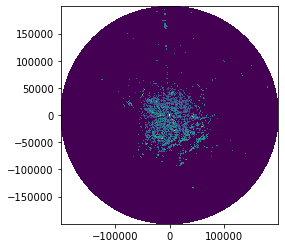

In [45]:
vol[-1].data.pipe(wrl.georef.georeference_dataset).DBZH[0].wradlib.plot()

### Plot same single sweep from Timeseries

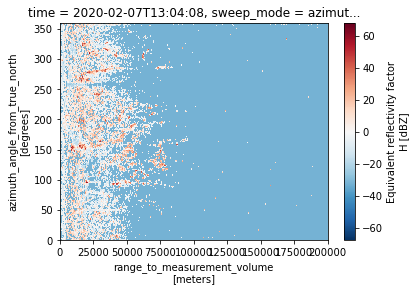

In [46]:
vol[-1].data.DBZH[0].plot()

## Exporting Data

Data can be exported to ODIMH5, CfRadial2 and NetCDF4.

### ODIMH5

ODIMH5 can only handle one volume not timeseries. So we have to select the timestep which we want to export.

The example shows, how to output the volume to a ODIMH5-file, read it back and check for equality.

In [47]:
vol.to_odim('test_odim.h5', timestep=5)

In [48]:
vol1 = wrl.io.open_odim('test_odim.h5')

Open:   0%|          | 0/1 [00:00<?, ? Files/s]

Open: 100%|██████████| 1/1 [00:00<00:00, 38.44 Files/s]


Collecting:   0%|          | 0/12 [00:00<?, ? Angles/s]

Collecting: 100%|██████████| 12/12 [00:00<00:00, 3622.55 Angles/s]

In [49]:
print(vol[0][5])

<wradlib.XRadSweepOdim>
Dimension(s): (azimuth: 360, range: 800)
Elevation(s): (25.0)
Moment(s): (VRAD, RHOHV, WRAD, DBZH)


In [50]:
print(vol1[0][0])

<wradlib.XRadSweepOdim>
Dimension(s): (azimuth: 360, range: 800)
Elevation(s): (25.0)
Moment(s): (DBZH, RHOHV, VRAD, WRAD)


In [51]:
xr.testing.assert_equal(vol[0][5].data, vol1[0][0].data)

### CfRadial2

CfRadial2 can only handle one volume not timeseries. So we have to select the timestep which we want to export.

The example shows, how to output the volume to a CfRadial2-file and read it back. For there is currently no fitting counterpart to `open_odim` for reading CfRadial2 volumes we resort to `wradlib.io.CfRadial` reader and compare the underlying numpy arrays.

In [52]:
vol.to_cfradial2('test_cfradial2.nc', timestep=5)

In [53]:
vol2 = wrl.io.CfRadial('test_cfradial2.nc', dim0='azimuth')

In [54]:
np.testing.assert_equal(vol[0][5].data.DBZH.values, vol2['sweep_0'].DBZH.values)

### NetCDF4

Using this, the complete volume/timeseries is exported to a NetCDF4 file.

The example shows, how to output the volume to such NetCDF4-file and read it back. For there is currently no fitting counterpart to `open_odim` for reading these NetCDF4 volumes we resort to `xarray.open_dataset` reader.

In [55]:
vol.to_netcdf('test_netcdf.nc', timestep=slice(None, None))

Collecting:   0%|          | 0/8 [00:00<?, ? Timesteps/s]

Collecting:  25%|██▌       | 2/8 [00:00<00:00, 16.72 Timesteps/s]

Collecting:  50%|█████     | 4/8 [00:00<00:00, 16.33 Timesteps/s]

Collecting:  88%|████████▊ | 7/8 [00:00<00:00, 17.49 Timesteps/s]

Collecting: 100%|██████████| 8/8 [00:00<00:00, 17.41 Timesteps/s]

Collecting:   0%|          | 0/8 [00:00<?, ? Timesteps/s]

Collecting:  25%|██▌       | 2/8 [00:00<00:00, 15.27 Timesteps/s]

Collecting:  50%|█████     | 4/8 [00:00<00:00, 15.97 Timesteps/s]

Collecting:  88%|████████▊ | 7/8 [00:00<00:00, 18.26 Timesteps/s]

Collecting: 100%|██████████| 8/8 [00:00<00:00, 19.65 Timesteps/s]

Collecting:   0%|          | 0/8 [00:00<?, ? Timesteps/s]

Collecting:  25%|██▌       | 2/8 [00:00<00:00, 12.18 Timesteps/s]

Collecting:  50%|█████     | 4/8 [00:00<00:00, 13.28 Timesteps/s]

Collecting:  88%|████████▊ | 7/8 [00:00<00:00, 15.44 Timesteps/s]

Collecting: 100%|██████████| 8/8 [00:00<00:00, 16.95 Timesteps/s]

Collecting:   0%|          | 0/8 [00:00<?, ? Timesteps/s]

Collecting:  25%|██▌       | 2/8 [00:00<00:00, 19.34 Timesteps/s]

Collecting:  50%|█████     | 4/8 [00:00<00:00, 18.30 Timesteps/s]

Collecting:  88%|████████▊ | 7/8 [00:00<00:00, 19.18 Timesteps/s]

Collecting: 100%|██████████| 8/8 [00:00<00:00, 17.24 Timesteps/s]

Collecting:   0%|          | 0/8 [00:00<?, ? Timesteps/s]

Collecting:  25%|██▌       | 2/8 [00:00<00:00, 17.93 Timesteps/s]

Collecting:  50%|█████     | 4/8 [00:00<00:00, 17.79 Timesteps/s]

Collecting:  88%|████████▊ | 7/8 [00:00<00:00, 18.74 Timesteps/s]

Collecting: 100%|██████████| 8/8 [00:00<00:00, 18.21 Timesteps/s]

Collecting:   0%|          | 0/8 [00:00<?, ? Timesteps/s]

Collecting:  25%|██▌       | 2/8 [00:00<00:00, 17.56 Timesteps/s]

Collecting:  50%|█████     | 4/8 [00:00<00:00, 17.57 Timesteps/s]

Collecting:  88%|████████▊ | 7/8 [00:00<00:00, 18.64 Timesteps/s]

Collecting: 100%|██████████| 8/8 [00:00<00:00, 18.18 Timesteps/s]

Collecting:   0%|          | 0/8 [00:00<?, ? Timesteps/s]

Collecting:  25%|██▌       | 2/8 [00:00<00:00, 18.89 Timesteps/s]

Collecting:  50%|█████     | 4/8 [00:00<00:00, 18.15 Timesteps/s]

Collecting:  88%|████████▊ | 7/8 [00:00<00:00, 17.54 Timesteps/s]

Collecting: 100%|██████████| 8/8 [00:00<00:00, 16.77 Timesteps/s]

Collecting:   0%|          | 0/8 [00:00<?, ? Timesteps/s]

Collecting:  25%|██▌       | 2/8 [00:00<00:00, 17.20 Timesteps/s]

Collecting:  50%|█████     | 4/8 [00:00<00:00, 16.60 Timesteps/s]

Collecting:  88%|████████▊ | 7/8 [00:00<00:00, 18.07 Timesteps/s]

Collecting: 100%|██████████| 8/8 [00:00<00:00, 18.03 Timesteps/s]

Collecting:   0%|          | 0/8 [00:00<?, ? Timesteps/s]

Collecting:  25%|██▌       | 2/8 [00:00<00:00, 13.16 Timesteps/s]

Collecting:  50%|█████     | 4/8 [00:00<00:00, 13.43 Timesteps/s]

Collecting:  88%|████████▊ | 7/8 [00:00<00:00, 14.44 Timesteps/s]

Collecting: 100%|██████████| 8/8 [00:00<00:00, 14.89 Timesteps/s]

Collecting:   0%|          | 0/8 [00:00<?, ? Timesteps/s]

Collecting:  25%|██▌       | 2/8 [00:00<00:00, 15.34 Timesteps/s]

Collecting:  50%|█████     | 4/8 [00:00<00:00, 14.77 Timesteps/s]

Collecting:  88%|████████▊ | 7/8 [00:00<00:00, 16.28 Timesteps/s]

Collecting: 100%|██████████| 8/8 [00:00<00:00, 16.31 Timesteps/s]

Collecting:   0%|          | 0/8 [00:00<?, ? Timesteps/s]

Collecting:  25%|██▌       | 2/8 [00:00<00:00, 16.75 Timesteps/s]

Collecting:  50%|█████     | 4/8 [00:00<00:00, 15.46 Timesteps/s]

Collecting:  62%|██████▎   | 5/8 [00:00<00:00, 13.25 Timesteps/s]

Collecting: 100%|██████████| 8/8 [00:00<00:00, 14.15 Timesteps/s]

Collecting: 100%|██████████| 8/8 [00:00<00:00, 14.28 Timesteps/s]

In [56]:
vol3 = xr.open_dataset('test_netcdf.nc', group='sweep_0')

In [57]:
xr.testing.assert_equal(vol[0][5].data, vol3.isel(time=5))

## Delete object

In [58]:
del mom
del swp
del ts
del vol
del vol1
del vol2
del vol3

## Run Garbage Collection

In [59]:
free_memory()

47361
Memory freed: 12.00000 MB


## Check Memory

In [60]:
mem_end = memory_usage_psutil()
print("Memory: {} - {}".format(mem_start, mem_end))
print("Memory still in use: {0:.5f} MB".format((mem_end-mem_start)))

Memory: 124.3359375 - 322.41796875
Memory still in use: 198.08203 MB


## Check Open files

No open data files!

In [61]:
check_open_files(True)

2
[popenfile(path='/home/travis/micromamba/envs/travis_wradlib/share/proj/proj.db', fd=75, position=40, mode='r', flags=688128), popenfile(path='/home/travis/micromamba/envs/travis_wradlib/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', fd=78, position=69642, mode='r', flags=557056)]
